In [1]:
#Importing the necessary modules


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

Epoch 1/25
69/69 [==============================] - 5s 74ms/step - loss: 0.0047
Epoch 2/25
69/69 [==============================] - 5s 67ms/step - loss: 0.0014
Epoch 3/25
69/69 [==============================] - 4s 56ms/step - loss: 0.0015
Epoch 4/25
69/69 [==============================] - 4s 57ms/step - loss: 0.0012
Epoch 5/25
69/69 [==============================] - 4s 58ms/step - loss: 0.0015
Epoch 6/25
69/69 [==============================] - 4s 64ms/step - loss: 0.0013
Epoch 7/25
69/69 [==============================] - 5s 79ms/step - loss: 0.0011
Epoch 8/25
69/69 [==============================] - 5s 69ms/step - loss: 0.0013
Epoch 9/25
69/69 [==============================] - 5s 77ms/step - loss: 0.0013
Epoch 10/25
69/69 [==============================] - 5s 70ms/step - loss: 0.0012
Epoch 11/25
69/69 [==============================] - 5s 72ms/step - loss: 0.0011
Epoch 12/25
69/69 [==============================] - 5s 74ms/step - loss: 0.0011
Epoch 13/25
69/69 [==================

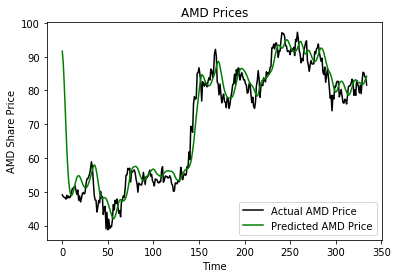

Prediction is [[84.51693]]


In [4]:
#Load data

#Companies for Test 
#  "FB"  Facebook, "TSLA" - Tesla, "AMZN"- Amazon , "BTC-USD" - Bitcoin, "AAPL"- Apple
company = 'AMD'

start = dt.datetime(2012,1,1)#Start date
end = dt.datetime(2021,1,1)#End date

data = web.DataReader(company, 'yahoo', start, end) #Taking the data from yahoo

#Prepare Data

scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 63 # We are going to train on last 62 days data, and predict the next day price

x_train = []
y_train = []

for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])
    


x_train , y_train = np.array(x_train),np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

#Build the model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences =True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))#Prediction

model.compile(optimizer= 'adam',loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 25 , batch_size = 32)

#Test the model on existing data

#load test_data
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo',test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']), axis = 0)


model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
    

x_test = np.array(x_test)

x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))


predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
print(predicted_prices)

#Plot

plt.plot(actual_prices,color = 'black', label = f'Actual {company} Price')
plt.plot(predicted_prices, color = 'green', label = f'Predicted {company} Price')
plt.title(f'{company} Prices')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


#Prediction next day price

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]

real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f'Prediction is {prediction}')


